# Compare models

In [ ]:
import os
import random
import torch
import numpy as np
print(torch.cuda.is_available())

from src.data.data_converter import tokens_to_weights, weights_to_flattened_weights, flattened_weights_to_weights
from src.data.inr_dataset import INRDataset
from src.data.utils import get_files_from_selectors
from src.data.inr import INR

from src.core.config import TransformerExperimentConfig, DataConfig, DataSelector, DatasetType
from src.core.config_diffusion import DiffusionExperimentConfig

from src.models.diffusion.pl_diffusion import HyperDiffusion
from src.models.autoencoder.pl_transformer import Autoencoder

from src.evaluation import model_utils, visualization_utils, metrics


%load_ext autoreload
%autoreload 2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

### 1. Create Hyperdiffusion model

In [ ]:
config: DiffusionExperimentConfig = DiffusionExperimentConfig.sanity()

config.transformer_config.n_embd = 1024
config.transformer_config.n_head = 8
config.transformer_config.n_layer = 8
config.data = DataConfig.small()
config.data.selector = DataSelector(dataset_type=DatasetType.MNIST, class_label=2)

mlp = INR(up_scale=16)
mlp.eval()

data_path = os.path.join(os.getcwd(), config.data.data_path)
files = get_files_from_selectors(data_path, [config.data.selector])
dataset_flattened = INRDataset(files, "cpu", is_flattened=True)

ref_cp = dataset_flattened.get_state_dict(0)

data_shape = dataset_flattened[0].unsqueeze(0).shape
# Initialize model
hyperdiffusion = HyperDiffusion(
    config, data_shape
)
hyperdiffusion.eval()

#checkpoint = "good_checkpoints/ferdy/hyperdiffusion/standard_hyperdiffusion.ckpt"
checkpoint = "good_checkpoints/ferdy/hyperdiffusion/hyperdiffusion_20250126_132035.ckpt"
state_dict = torch.load(checkpoint, map_location=torch.device('cpu'))["state_dict"]
hyperdiffusion.load_state_dict(state_dict)
print("Dataset size:", len(dataset_flattened))

### 2. Create VAE

In [53]:
config_ae: TransformerExperimentConfig = TransformerExperimentConfig.default()
config_ae.model.num_heads = 8
config_ae.model.num_layers = 8
config_ae.model.d_model = 512  # 256 -> 4
config_ae.model.latent_dim = 8
config_ae.model.layer_norm = False
config_ae.model.use_mask = True

autoencoder_checkpoint = "good_checkpoints/best_overfit_so_far_099_split.ckpt"
#autoencoder_checkpoint = "good_checkpoints/overfit.ckpt"
# Initialize model
vae = Autoencoder(config_ae)
vae.eval()
state_dict = torch.load(autoencoder_checkpoint, map_location=torch.device('cpu'))
vae.load_state_dict(state_dict["state_dict"])
sum(p.numel() for p in vae.parameters())

50473170

### 3. Create Stable Hyperdiffusion Model

In [ ]:
config_shyp: DiffusionExperimentConfig = DiffusionExperimentConfig.sanity()
config_shyp.transformer_config.n_embd = 512
config_shyp.transformer_config.n_head = 8
config_shyp.transformer_config.n_layer = 8

dataset_tokenized = INRDataset(files, "cpu", is_flattened=False)

data_shape = (config.data.batch_size, config_ae.model.n_tokens * config_ae.model.latent_dim)
_,_,positions = dataset_tokenized[0]

# Initialize model
stable_hyperdiffusion = HyperDiffusion(
    config_shyp, data_shape, vae, positions
)

diffusion_checkpoint = "diffusion_logs/lightning_checkpoints/stable_hyperdiffusion_whole_dataset_2025-01-24 16-17-16.651982-hyperdiffusion_num2 20250124_161713-z8ljsssp/last.ckpt"
state_dict = torch.load(diffusion_checkpoint, map_location=torch.device('cpu'))
stable_hyperdiffusion.load_state_dict(state_dict["state_dict"])
stable_hyperdiffusion.eval()
print("")

### 4. Visualize the results

In [ ]:
n_samples = 100
mlp = mlp.to(device)
hyperdiffusion = hyperdiffusion.to(device)

In [ ]:
path = "evaluation/hyperdiffusion"
os.makedirs(path, exist_ok=True)
for i in range(100):
    hyperdiffusion_images = model_utils.generate_diffusion_images(hyperdiffusion, mlp, n_samples, ref_cp=ref_cp)
    hyperdiffusion_images_numpy = np.array(hyperdiffusion_images)
    print(hyperdiffusion_images_numpy.shape)
    np.save(os.path.join(path, f"hyperdiffusion_images{i}.npy"), hyperdiffusion_images_numpy)

In [43]:
path = "evaluation/hyperdiffusion"
file_paths = [os.path.join(root, file) for root, _, files in os.walk(path) for file in files]
combined = []
for file_path in file_paths:
    array = np.load(file_path)
    combined.extend(array)
hyperdiffusion_images = combined

In [9]:
dataset_images = [model_utils.compute_image(mlp, flattened_weights_to_weights(dataset_flattened[i], mlp)) for i in range(len(dataset_flattened))]
dataset_images_array = torch.Tensor(dataset_images)
dataset_images_array = dataset_images_array.view(dataset_images_array.size(0), -1)
print(dataset_images_array.shape)

torch.Size([6990, 784])


C:\Users\simon\AppData\Local\Temp\ipykernel_5152\1816167257.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_fakvb73nko\croot\pytorch-select_1730848725921\work\torch\csrc\utils\tensor_new.cpp:277.)
  dataset_images_array = torch.Tensor(dataset_images)


In [10]:
hyperdiffusion_images_array =  torch.Tensor(hyperdiffusion_images)
hyperdiffusion_images_array = hyperdiffusion_images_array.view(hyperdiffusion_images_array.size(0), -1)
print(hyperdiffusion_images_array.shape)

torch.Size([1700, 784])


In [16]:
indices, distances = metrics.find_nearest_neighbor(hyperdiffusion_images_array, dataset_images_array)

tensor([[0.5655],
        [0.1958],
        [0.5099],
        ...,
        [0.3820],
        [0.5619],
        [0.2489]])


In [38]:
distances = distances.view(-1)
idx = np.argsort(distances)[200:300]

In [ ]:
for i in range(len(idx) // 6):
    pos = i*6 
    print(f"    {idx[pos]}                       {idx[pos+1]}                       {idx[pos+2]}                       {idx[pos+3]}                       {idx[pos+4]}                       {idx[pos+5]}")
    images = [hyperdiffusion_images[j] for j in idx[i*6:i*6+6]]
    visualization_utils.plot_n_images(images, row=True)

In [42]:
stable_hyperdiffusion_images = model_utils.generate_diffusion_images(stable_hyperdiffusion, mlp, 5, ref_cp=ref_cp)

In [50]:
images = dataset_images[:5]
images.extend(stable_hyperdiffusion_images)
images.append(hyperdiffusion_images[1407])
images.append(hyperdiffusion_images[934])
images.append(hyperdiffusion_images[1143])
images.append(hyperdiffusion_images[500])
images.append(hyperdiffusion_images[946])
print(len(images))

15


Number of samples: 15


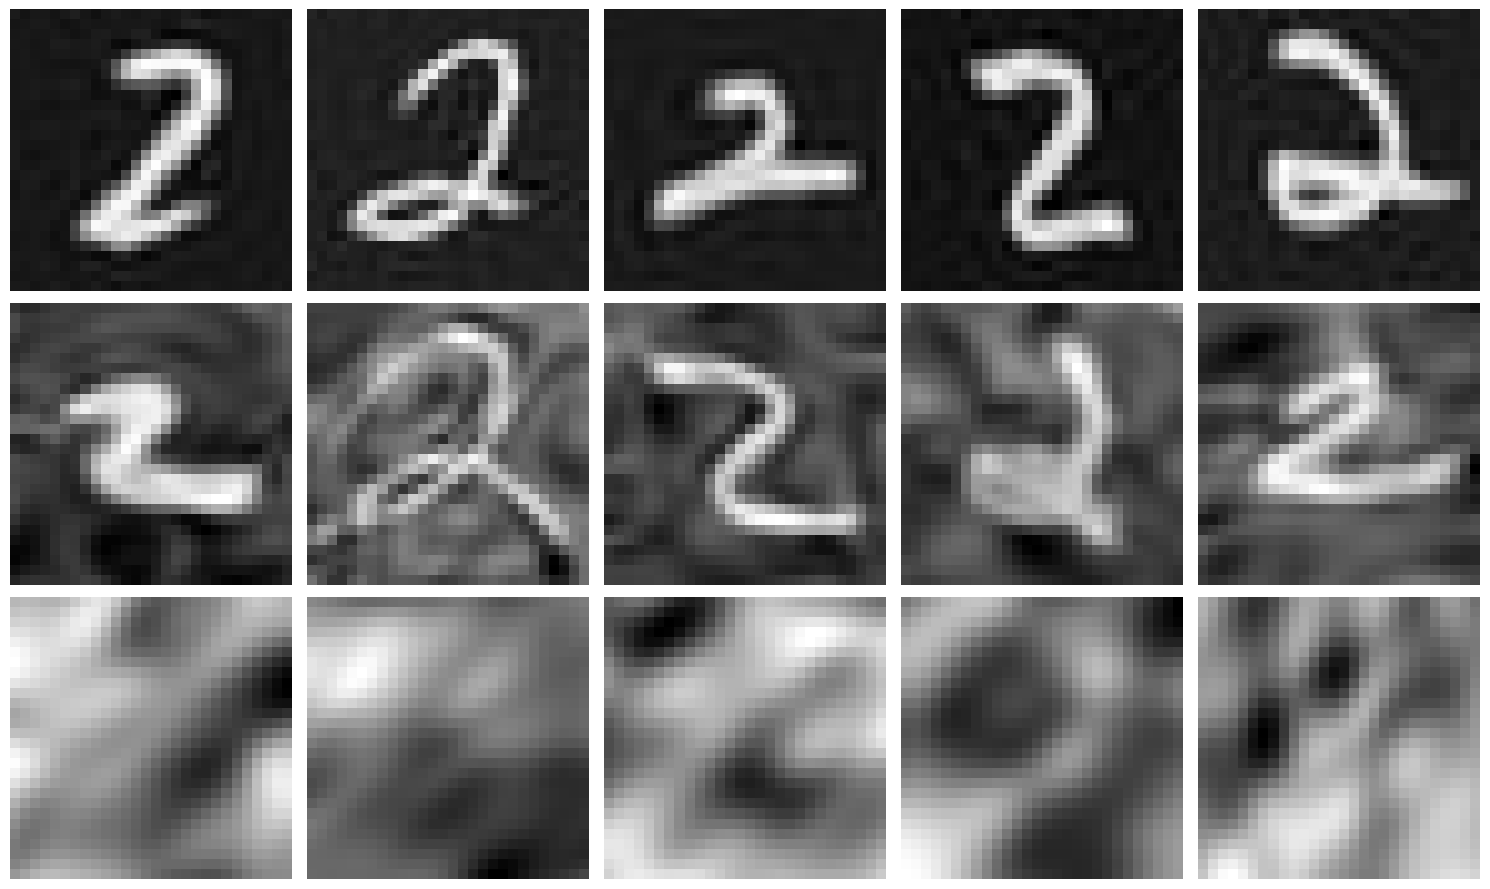

In [52]:
visualization_utils.plot_n_images(images, rows=3, cols=5)

### 5. Calculate metrics

#### 5.1 Image comparison

In [71]:
num_samples = 200
hyperdiffusion_results = hyperdiffusion.generate_samples(num_samples)
stable_hyperdiffusion_latent_outputs, stable_hyperdiffusion_results, stable_hyperdiffusion_positions = stable_hyperdiffusion.generate_samples(num_samples)

In [ ]:
print(hyperdiffusion_results.shape)
print(stable_hyperdiffusion_results.shape)
print(stable_hyperdiffusion_latent_outputs.shape)

In [ ]:
# Get n random samples from dataset
indices = random.sample(range(len(dataset_flattened)), num_samples)
dataset_samples = [dataset_flattened[i] for i in indices]
dataset_samples = torch.stack(dataset_samples)
print(dataset_samples.shape)

In [ ]:
stable_hyperdiffusion_results_flattened = [weights_to_flattened_weights(tokens_to_weights(t, p, ref_cp)) for t, p in zip(stable_hyperdiffusion_results, stable_hyperdiffusion_positions)]
stable_hyperdiffusion_results_flattened = torch.stack(stable_hyperdiffusion_results_flattened)
print(stable_hyperdiffusion_results_flattened.shape)

In [83]:
# Generate images and stack to tensor
hyperdiffusion_images = [torch.from_numpy(model_utils.compute_image(mlp, flattened_weights_to_weights(s, mlp))) for s in hyperdiffusion_results]
hyperdiffusion_images = torch.stack(hyperdiffusion_images)
stable_hyperdiffusion_images = [torch.from_numpy(model_utils.compute_image(mlp, flattened_weights_to_weights(s, mlp))) for s in stable_hyperdiffusion_results_flattened]
stable_hyperdiffusion_images = torch.stack(stable_hyperdiffusion_images)
dataset_images = [torch.from_numpy(model_utils.compute_image(mlp, flattened_weights_to_weights(s, mlp))) for s in dataset_samples]
dataset_images = torch.stack(dataset_images)

##### Calculate FID scores:

In [ ]:
fid_hyperdiffusion = metrics.calculate_fid(dataset_images, hyperdiffusion_images)
fid_stable_hyperdiffusion = metrics.calculate_fid(dataset_images, stable_hyperdiffusion_images)
print(f"FID Hyperdiffusion: {fid_hyperdiffusion}")
print(f"FID Stable Hyperdiffusion: {fid_stable_hyperdiffusion}")

##### Calculate MSE scores:

In [ ]:
mse_hyperdiffusion = metrics.calculate_mse(dataset_images, hyperdiffusion_images)
mse_stable_hyperdiffusion = metrics.calculate_mse(dataset_images, stable_hyperdiffusion_images)
print(f"MSE Hyperdiffusion: {mse_hyperdiffusion}")
print(f"MSE Stable Hyperdiffusion: {mse_stable_hyperdiffusion}")

##### Calculate the Minimum Matching Distance

In [ ]:
mmd_hyperdiffusion = metrics.compute_mmd(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
mmd_stable_hyperdiffusion = metrics.compute_mmd(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"Minimum Matching Distance Hyperdiffusion: {mmd_hyperdiffusion}")
print(f"Minimum Matching Distance Stable Hyperdiffusion: {mmd_stable_hyperdiffusion}")

##### Calculate the coverage

In [ ]:
coverage_hyperdiffusion = metrics.compute_coverage(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
coverage_stable_hyperdiffusion = metrics.compute_coverage(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"Coverage Hyperdiffusion: {coverage_hyperdiffusion}")
print(f"Coverage Stable Hyperdiffusion: {coverage_stable_hyperdiffusion}")

##### Calculate the 1-Nearest-Neighbor Accuracy

In [ ]:
nna_hyperdiffusion = metrics.compute_1nna(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
nna_stable_hyperdiffusion = metrics.compute_1nna(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"1-Nearest-Neighbor Accuracy Hyperdiffusion: {nna_hyperdiffusion}")
print(f"1-Nearest-Neighbor Accuracy Stable Hyperdiffusion: {nna_stable_hyperdiffusion}")

##### Calculate the novelty

In [ ]:
# NOTE: maybe we should use the whole training dataset here
novelty_hyperdiffusion = metrics.detect_novelty(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
novelty_stable_hyperdiffusion = metrics.detect_novelty(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"Novelty Hyperdiffusion: {novelty_hyperdiffusion[0].sum()} of {len(novelty_hyperdiffusion[0])}")
print(f"Novelty Stable Hyperdiffusion: {novelty_stable_hyperdiffusion[0].sum()} of {len(novelty_stable_hyperdiffusion[0])}")

In [ ]:
novelty_hyperdiffusion = metrics.novelty_svm(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
novelty_stable_hyperdiffusion = metrics.novelty_svm(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"Novelty Hyperdiffusion: {novelty_hyperdiffusion}")
print(f"Novelty Stable Hyperdiffusion: {novelty_stable_hyperdiffusion}")

#### 5.2 Weights comparison

In [106]:
#TODO:

### 6. VAE Latent Space

#### Sample from latent space

In [ ]:
num_samples = 50
latent_images = model_utils.sample_from_latent_space(
    vae, mlp, ref_cp, dataset_tokenized[0][2], config_ae.model.n_tokens, config_ae.model.latent_dim, n_samples
)
visualization_utils.plot_n_images(latent_images)

##### Interpolate latent space

In [ ]:
num_interpolation_steps = 10

num_interpolations = 100

for i in range(num_interpolations):
    idx = random.randint(0, len(dataset_tokenized) - 1)
    idy = random.randint(0, len(dataset_tokenized) - 1)
    latent_vectors = [dataset_tokenized[idx][0], dataset_tokenized[idy][0]]
    latent_positions = [dataset_tokenized[idx][2], dataset_tokenized[idy][2]]
    latent_vectors = torch.stack(latent_vectors)
    latent_positions = torch.stack(latent_positions)

    vae.eval()
    with torch.no_grad():
        latent_vector, _, _ = vae.encoder(latent_vectors, latent_positions)

    latent_images = model_utils.interpolate_latent_space(
        latent_vector[0], latent_vector[1], num_interpolation_steps, dataset_tokenized[0][2], vae, ref_cp, mlp
    )
    print("Indices:", idx, idy)
    visualization_utils.plot_n_images(latent_images, row=True)

In [47]:
images, recons, mse_weights, mse_images = model_utils.get_n_images_and_mses(vae, dataset_tokenized, mlp, len(dataset_tokenized), device=device, random=False)

In [48]:
best_mse_weight_indices = model_utils.get_best_samples(mse_weights, best_n=10)
best_mse_image_indices = model_utils.get_best_samples(mse_images, best_n=10)

In [ ]:
for i in best_mse_image_indices:
    for j in best_mse_image_indices:
        latent_vectors = [dataset_tokenized[i][0], dataset_tokenized[j][0]]
        latent_positions = [dataset_tokenized[i][2], dataset_tokenized[j][2]]
        latent_vectors = torch.stack(latent_vectors)
        latent_positions = torch.stack(latent_positions)

        vae.eval()
        with torch.no_grad():
            latent_vector, _, _ = vae.encoder(latent_vectors, latent_positions)

        latent_images = model_utils.interpolate_latent_space(
            latent_vector[0], latent_vector[1], num_interpolation_steps, dataset_tokenized[0][2], vae, ref_cp, mlp
        )
        visualization_utils.plot_n_images(latent_images, row=True)

### 7. Get nearest neighbors

In [123]:
num_samples = 30
k = 2
dataset_images, hyperdiffusion_images, mse_images, mse_weights, distances = model_utils.generate_nearest_neighbors(hyperdiffusion, 
                                                                                                                  inr=mlp,
                                                                                                                  dataset=dataset_flattened,
                                                                                                                  num_samples=30,
                                                                                                                  k=k)

In [ ]:
visualization_utils.plot_diffusion_knn(
    hyperdiffusion_images,
    dataset_images,
    mse_images,
    mse_weights,
    k=k,
    num_samples=num_samples
)

In [125]:
dataset_images, stable_hyperdifusion_images, mse_images, mse_weights, distances = model_utils.generate_nearest_neighbors(stable_hyperdiffusion, 
                                                                                                                  inr=mlp,
                                                                                                                  dataset=dataset_tokenized,
                                                                                                                  num_samples=30,
                                                                                                                  k=k)

In [ ]:
visualization_utils.plot_diffusion_knn(
    stable_hyperdifusion_images,
    dataset_images,
    mse_images,
    mse_weights,
    k=k,
    num_samples=num_samples
)